# TPDA Classification (Bivariate, 3 Classes) with Fenchel-Young Loss

We generate a 3-class dataset with equal priors, where each class-conditional density is a bivariate truncated parabola:

$$
\hat p_c(t)=\left[-\tau_c-\frac12(t-\mu_c)^\top\Sigma_c^{-1}(t-\mu_c)\right]_+,
$$

$$
Q_c(t):=(t-\mu_c)^\top\Sigma_c^{-1}(t-\mu_c),
\qquad
\tau_c=-\left(\frac{\Gamma\!\left(\frac{N}{2}+2\right)}{\sqrt{(2\pi)^N\det(\Sigma_c)}}\right)^{\frac{2}{N+2}},\quad N=2.
$$

Now class priors are **trainable**: $\pi=\mathrm{softmax}(\rho)$, with $\sum_c \pi_c=1$.
For a labeled sample $(t_0,c_0)$, we optimize the attached joint FY loss:

$$
\ell_{\mathrm{joint}}(t_0,c_0)
=\frac12-\frac{2}{N+4}\sum_{c=1}^{K}\pi_c^2\tau_c
+\pi_{c_0}\left(\frac12Q_{c_0}(t_0)+\tau_{c_0}\right).
$$


In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch

np.random.seed(13)
torch.manual_seed(13)


In [2]:
def tau_from_cov(cov):
    # cov: (2, 2) SPD numpy array
    n = cov.shape[0]
    det_term = np.linalg.det(2.0 * np.pi * cov)
    numerator = math.gamma(n / 2.0 + 2.0)
    return - (numerator / np.sqrt(det_term)) ** (2.0 / (n + 2.0))


def density_bivariate_trunc_parabola(x, mu, cov):
    # x: (..., 2)
    inv_cov = np.linalg.inv(cov)
    delta = x - mu
    maha = np.einsum('...i,ij,...j->...', delta, inv_cov, delta)
    tau = tau_from_cov(cov)
    return np.maximum(-tau - 0.5 * maha, 0.0)


def support_radius_for_ball_envelope(cov):
    # Conservative Euclidean envelope from Mahalanobis support.
    tau = tau_from_cov(cov)
    inv_cov = np.linalg.inv(cov)
    lam_min = np.linalg.eigvalsh(inv_cov).min()
    return np.sqrt(2.0 * (-tau) / lam_min)


def sample_bivariate_trunc_parabola(mu, cov, n, batch_size=8192):
    tau = tau_from_cov(cov)
    fmax = -tau
    r = support_radius_for_ball_envelope(cov)

    out = []
    while len(out) < n:
        x = np.random.uniform(mu - r, mu + r, size=(batch_size, 2))
        y = np.random.uniform(0.0, fmax, size=batch_size)
        fx = density_bivariate_trunc_parabola(x, mu, cov)
        accepted = x[y <= fx]
        out.extend(accepted.tolist())

    return np.array(out[:n], dtype=np.float64)


In [3]:
# Generate 3-class data with equal priors
K = 3
N = 2
n_per_class = 1800

mu_true = np.array([
    [-2.0, -1.0],
    [ 2.1, -0.6],
    [ 0.2,  2.2],
], dtype=np.float64)

Sigma_true = np.array([
    [[0.80, 0.25], [0.25, 0.95]],
    [[1.05, -0.30], [-0.30, 0.85]],
    [[0.90, 0.15], [0.15, 0.75]],
], dtype=np.float64)

X_list = []
y_list = []
for k in range(K):
    Xk = sample_bivariate_trunc_parabola(mu_true[k], Sigma_true[k], n_per_class)
    yk = np.full(n_per_class, k, dtype=np.int64)
    X_list.append(Xk)
    y_list.append(yk)

X = np.vstack(X_list)
y = np.concatenate(y_list)

perm = np.random.permutation(len(X))
X = X[perm]
y = y[perm]

# Train/test split
n_train = int(0.8 * len(X))
X_train, y_train = X[:n_train], y[:n_train]
X_test, y_test = X[n_train:], y[n_train:]

print('Train shape:', X_train.shape, y_train.shape)
print('Test shape: ', X_test.shape, y_test.shape)
print('Class counts (train):', np.bincount(y_train, minlength=K))


Train shape: (4320, 2) (4320,)
Test shape:  (1080, 2) (1080,)
Class counts (train): [1420 1471 1429]


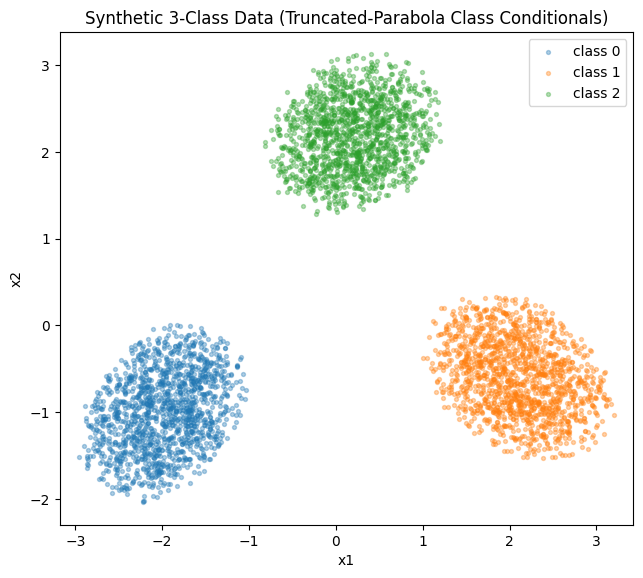

In [4]:
# Visualize generated data
colors = ['tab:blue', 'tab:orange', 'tab:green']

plt.figure(figsize=(7.4, 6.4))
for k in range(K):
    idx = (y_train == k)
    plt.scatter(X_train[idx, 0], X_train[idx, 1], s=8, alpha=0.35, color=colors[k], label=f'class {k}')

plt.title('Synthetic 3-Class Data (Truncated-Parabola Class Conditionals)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.axis('equal')
plt.legend()
plt.show()


In [5]:
# Fenchel-Young (single-distribution form) is applied per example to its true class.
# We keep training objective explicit in terms of (mu_k, Sigma_k) instead of a multiclass sparsemax surrogate.


In [6]:
def build_cov_from_raw(raw_diag, raw_offdiag):
    # raw_diag: (K,2), raw_offdiag: (K,1)
    l11 = torch.nn.functional.softplus(raw_diag[:, 0]) + 1e-5
    l22 = torch.nn.functional.softplus(raw_diag[:, 1]) + 1e-5
    l21 = raw_offdiag[:, 0]

    row1 = torch.stack([l11, torch.zeros_like(l11)], dim=1)
    row2 = torch.stack([l21, l22], dim=1)
    L = torch.stack([row1, row2], dim=1)  # (K,2,2)

    eye = torch.eye(2, device=L.device, dtype=L.dtype).unsqueeze(0)
    cov = L @ L.transpose(1, 2) + 1e-6 * eye
    return cov


def tau_from_cov_torch(cov):
    # cov: (K,2,2)
    n = cov.shape[-1]
    det_term = torch.det(cov)
    numerator = math.gamma(n / 2.0 + 2.0)
    denom = torch.sqrt((2.0 * torch.pi) ** n * det_term)
    return - (numerator / denom) ** (2.0 / (n + 2.0))


def tpda_class_scores(x, mu, cov, priors):
    # x: (B,2), mu: (K,2), cov: (K,2,2), priors: (K,)
    inv_cov = torch.inverse(cov)               # (K,2,2)
    delta = x[:, None, :] - mu[None, :, :]     # (B,K,2)
    maha = torch.einsum('bki,kij,bkj->bk', delta, inv_cov, delta)

    tau = tau_from_cov_torch(cov)              # (K,)
    densities = torch.relu(-tau[None, :] - 0.5 * maha)
    return priors[None, :] * densities


def tpda_joint_fy_loss(x, y, mu, cov, prior_logits):
    # Per-example attached joint FY loss with trainable priors.
    inv_cov = torch.inverse(cov)               # (K,2,2)
    delta = x[:, None, :] - mu[None, :, :]     # (B,K,2)
    maha = torch.einsum('bki,kij,bkj->bk', delta, inv_cov, delta)

    tau = tau_from_cov_torch(cov)              # (K,)
    pi = torch.softmax(prior_logits, dim=0)    # (K,)
    n = x.shape[1]

    term_global = 0.5 - (2.0 / (n + 4.0)) * torch.sum((pi ** 2) * tau)

    tau_y = tau.gather(0, y)
    pi_y = pi.gather(0, y)
    q_y = maha.gather(1, y[:, None]).squeeze(1)

    loss_i = term_global + pi_y * (0.5 * q_y + tau_y)
    return loss_i


In [7]:
# Fit TPDA with gradient-based optimization using joint FY loss and trainable priors
Xtr = torch.tensor(X_train, dtype=torch.float32)
ytr = torch.tensor(y_train, dtype=torch.long)
Xte = torch.tensor(X_test, dtype=torch.float32)
yte = torch.tensor(y_test, dtype=torch.long)

mu = torch.nn.Parameter(torch.randn(K, N) * 0.5)
raw_diag = torch.nn.Parameter(torch.zeros(K, N))
raw_offdiag = torch.nn.Parameter(torch.zeros(K, 1))
prior_logits = torch.nn.Parameter(torch.zeros(K))

optimizer = torch.optim.Adam([mu, raw_diag, raw_offdiag, prior_logits], lr=0.04)

loss_hist = []
train_acc_hist = []
test_acc_hist = []

for step in range(1400):
    optimizer.zero_grad()

    cov = build_cov_from_raw(raw_diag, raw_offdiag)
    loss = tpda_joint_fy_loss(Xtr, ytr, mu, cov, prior_logits).mean()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        cov_eval = build_cov_from_raw(raw_diag, raw_offdiag)
        priors_eval = torch.softmax(prior_logits, dim=0)

        scores_tr = tpda_class_scores(Xtr, mu, cov_eval, priors_eval)
        pred_tr = scores_tr.argmax(dim=1)
        train_acc = (pred_tr == ytr).float().mean().item()

        scores_te = tpda_class_scores(Xte, mu, cov_eval, priors_eval)
        pred_te = scores_te.argmax(dim=1)
        test_acc = (pred_te == yte).float().mean().item()

    loss_hist.append(float(loss.item()))
    train_acc_hist.append(train_acc)
    test_acc_hist.append(test_acc)

    if step % 200 == 0:
        pi_np = priors_eval.detach().cpu().numpy()
        print(f"step {step:4d} | loss={loss.item():.5f} | train_acc={train_acc:.4f} | test_acc={test_acc:.4f} | pi={pi_np}")

with torch.no_grad():
    cov_hat = build_cov_from_raw(raw_diag, raw_offdiag).detach().cpu().numpy()
    mu_hat = mu.detach().cpu().numpy()
    pi_hat = torch.softmax(prior_logits, dim=0).detach().cpu().numpy()

print('\nFitted means (mu_hat):\n', mu_hat)
print('\nFitted covariances (Sigma_hat):\n', cov_hat)
print('\nFitted priors (pi_hat):\n', pi_hat)
print(f"\nFinal train acc: {train_acc_hist[-1]:.4f}")
print(f"Final test  acc: {test_acc_hist[-1]:.4f}")


step    0 | loss=2.13883 | train_acc=0.3347 | test_acc=0.3583 | pi=[0.34210068 0.34210068 0.31579873]
step  200 | loss=0.45992 | train_acc=0.8944 | test_acc=0.8898 | pi=[0.46715254 0.47415194 0.05869555]
step  400 | loss=0.44437 | train_acc=0.9829 | test_acc=0.9796 | pi=[0.35322547 0.3723803  0.27439415]
step  600 | loss=0.43368 | train_acc=1.0000 | test_acc=1.0000 | pi=[0.32252762 0.32593572 0.3515367 ]
step  800 | loss=0.43192 | train_acc=0.9998 | test_acc=1.0000 | pi=[0.32240367 0.33141357 0.34618276]
step 1000 | loss=0.43144 | train_acc=1.0000 | test_acc=1.0000 | pi=[0.32671833 0.3381996  0.3350821 ]
step 1200 | loss=0.43141 | train_acc=0.9998 | test_acc=1.0000 | pi=[0.32842356 0.3402319  0.33134452]

Fitted means (mu_hat):
 [[-1.986734   -0.9895326 ]
 [ 2.0958588  -0.59237546]
 [ 0.19948846  2.1837595 ]]

Fitted covariances (Sigma_hat):
 [[[ 0.809395    0.26608288]
  [ 0.26608288  0.9475457 ]]

 [[ 1.0730028  -0.29865614]
  [-0.29865614  0.8968685 ]]

 [[ 0.82315797  0.12505439]
 

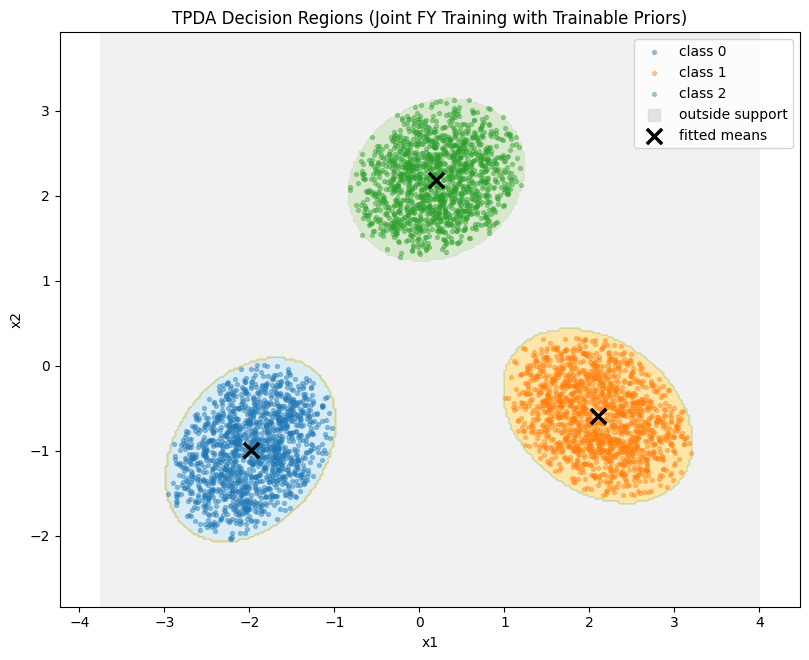

In [11]:
# Visualize fitted TPDA: decision regions + train data
import matplotlib.colors as mcolors

x_min, x_max = X[:, 0].min() - 0.8, X[:, 0].max() + 0.8
y_min, y_max = X[:, 1].min() - 0.8, X[:, 1].max() + 0.8

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 260), np.linspace(y_min, y_max, 260))
grid_np = np.stack([xx.ravel(), yy.ravel()], axis=1)

grid = torch.tensor(grid_np, dtype=torch.float32)
with torch.no_grad():
    cov = build_cov_from_raw(raw_diag, raw_offdiag)
    priors = torch.softmax(prior_logits, dim=0)
    scores_grid = tpda_class_scores(grid, mu, cov, priors)

    # Outside support: all class-conditional truncated-parabola scores are zero.
    outside_mask = (scores_grid.max(dim=1).values <= 1e-10)
    pred_grid = scores_grid.argmax(dim=1)
    pred_grid[outside_mask] = K
    pred_grid = pred_grid.cpu().numpy().reshape(xx.shape)

region_colors = ['#8ecae6', '#ffb703', '#90be6d', '#d9d9d9']  # class 0,1,2, outside
cmap = mcolors.ListedColormap(region_colors[:K] + [region_colors[-1]])

plt.figure(figsize=(8.2, 6.7))
plt.contourf(xx, yy, pred_grid, levels=np.arange(-0.5, K + 1.5, 1), alpha=0.35, cmap=cmap)

for k in range(K):
    idx = (y_train == k)
    plt.scatter(X_train[idx, 0], X_train[idx, 1], s=8, alpha=0.4, color=colors[k], label=f'class {k}')

# Legend entry for outside-support region
plt.scatter([], [], s=80, marker='s', color=region_colors[-1], alpha=0.7, label='outside support')

plt.scatter(mu_hat[:, 0], mu_hat[:, 1], c='black', s=120, marker='x', linewidths=2.5, label='fitted means')
plt.title('TPDA Decision Regions (Joint FY Training with Trainable Priors)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.axis('equal')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('TPDA.png', dpi=600)


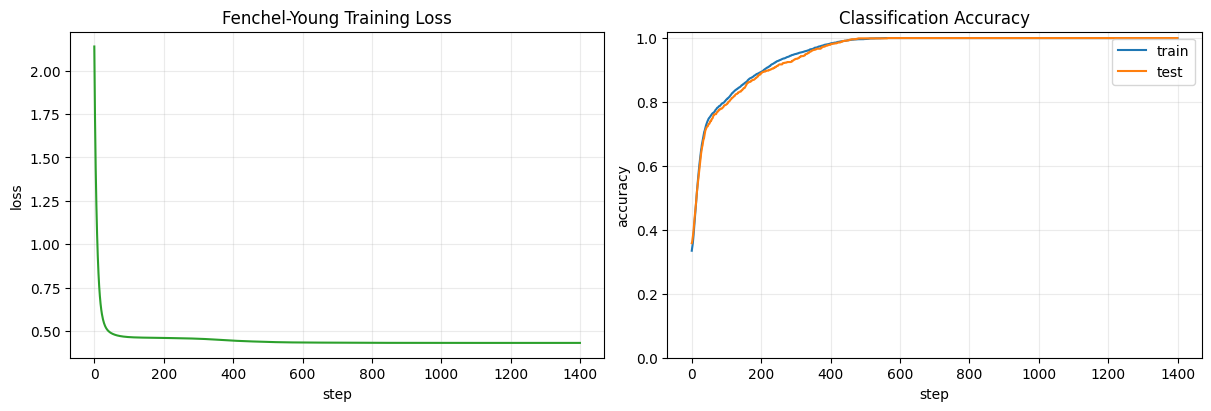

In [9]:
# Optimization curves
fig, ax = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

ax[0].plot(loss_hist, color='tab:green')
ax[0].set_title('Fenchel-Young Training Loss')
ax[0].set_xlabel('step')
ax[0].set_ylabel('loss')
ax[0].grid(alpha=0.25)

ax[1].plot(train_acc_hist, label='train', color='tab:blue')
ax[1].plot(test_acc_hist, label='test', color='tab:orange')
ax[1].set_title('Classification Accuracy')
ax[1].set_xlabel('step')
ax[1].set_ylabel('accuracy')
ax[1].set_ylim(0.0, 1.02)
ax[1].grid(alpha=0.25)
ax[1].legend()

plt.show()
